# Investigating the set of capacity factor time series

## Setup:

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.font_manager
import seaborn as sns

import os

# Interactive tables etc.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore all warnings including PyPSA logged ones: most of these are known trivial
# ones about old versions, Notebook settings, etc. but note you should probably
# comment this out at points to check for useful warnings!
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("pypsa").setLevel(level=logging.CRITICAL)  # ignore WARNING and below

# Style plots for better readability and accessibility
plt.style.use(['seaborn'])

### The time series data

In [2]:
# Getting all the data to analyse in one dict struct

# pickle file locations:
pkl_d = "/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_5/network_pkl_files"
models = ["CNRM", "ICHEC", "MPI"]
all_model_networks = {}
for model in models:
    networks = df2=pd.read_pickle(f"{pkl_d}/networks_per_period_{model}.pkl")
    all_model_networks[model] = networks

print(all_model_networks)

{'CNRM': {'1970-1976': Network nan, '1976-1982': Network nan, '1982-1988': Network nan, '1988-1994': Network nan, '1994-2000': Network nan, '2000-2006': Network nan, '2006-2012': Network nan, '2012-2018': Network nan, '2018-2024': Network nan, '2024-2030': Network nan, '2030-2038': Network nan, '2038-2044': Network nan, '2044-2050': Network nan, '2050-2056': Network nan, '2056-2062': Network nan, '2062-2070': Network nan, '2070-2076': Network nan, '2076-2082': Network nan, '2082-2088': Network nan, '2088-2094': Network nan, '2094-2101': Network nan}, 'ICHEC': {'1970-1976': Network nan, '1976-1982': Network nan, '1982-1988': Network nan, '1988-1994': Network nan, '1994-2000': Network nan, '2000-2006': Network nan, '2006-2012': Network nan, '2012-2018': Network nan, '2018-2024': Network nan, '2024-2030': Network nan, '2030-2038': Network nan, '2038-2044': Network nan, '2050-2056': Network nan, '2056-2062': Network nan, '2062-2070': Network nan, '2070-2076': Network nan, '2076-2082': Netw

## Picking out data

In [3]:
# Parameters to plot and investigate - change these as desired, too much info to
# look at at once (for now).
model = "ICHEC"

cap_factors_per_model = {}
for model in models:
    # Getting the right data:
    cap_factors = {}
    for period, network in all_model_networks[model].items():
        # CAN CHANGE FOR INVESTIGATION OF OTHER ASPECTS
        avg_capacity_factor = network.generators_t.p_max_pu # per generator
        cap_factors[period] = avg_capacity_factor
    cap_factors_per_model[model] = cap_factors
    
# Check that this is 3 as a basic check that the data structure is as it should be
assert len(cap_factors_per_model) == 3

# Check size
length = len(cap_factors_per_model["MPI"]["1970-1976"])  #=> (6 yr * 365 day/yr * 24 hrs/day) / 17528)  # = ~3 => 3-hourly data
print("DATA TAKEN EVERY", (6*365*24)/length, "HOURS")


DATA TAKEN EVERY 2.998630762209037 HOURS


## Plotting

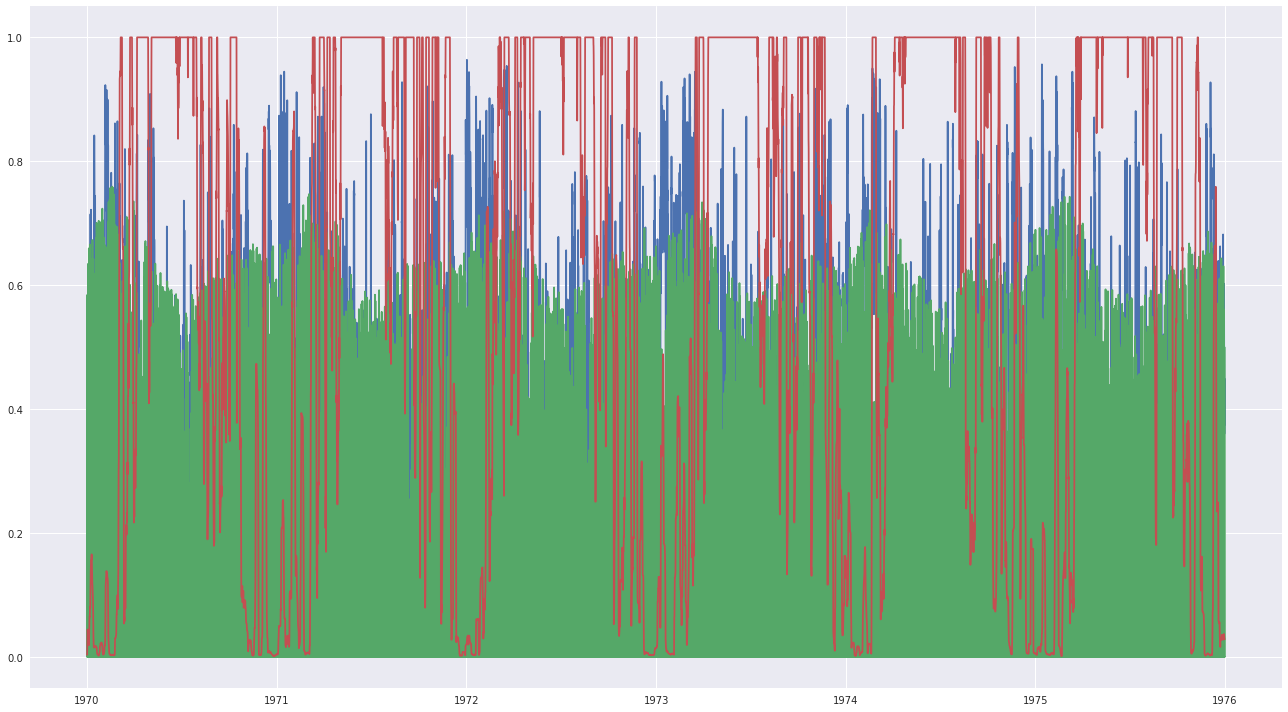

In [4]:
# Plot some representative values
country = "AT"
time_period = "1970-1976"
model = "MPI"

# Make the plot
cap_fac_to_plot = cap_factors_per_model[model][time_period]
fig, ax = plt.subplots(figsize=(18,10))
items_to_plot = []
for item in cap_fac_to_plot:
    if item.startswith(country):
        items_to_plot.append(item)
ts_to_consider = [cap_fac_to_plot[item] for item in [items_to_plot]]
ax.plot(*ts_to_consider)

# Format and show plot
fig.tight_layout()
fig.show()

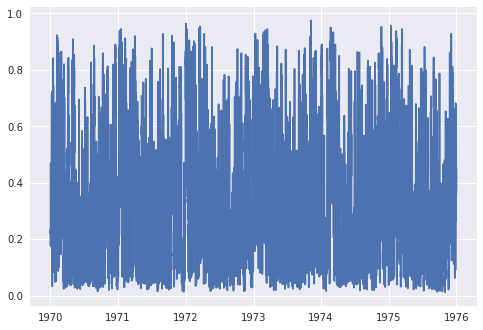

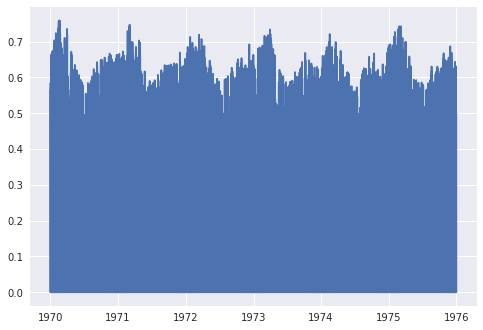

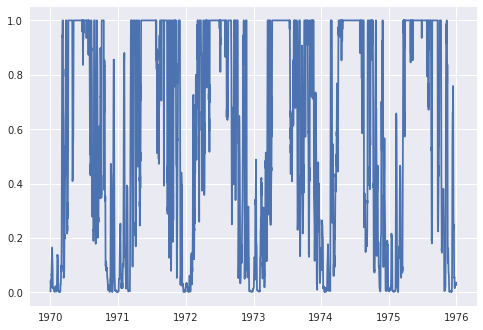

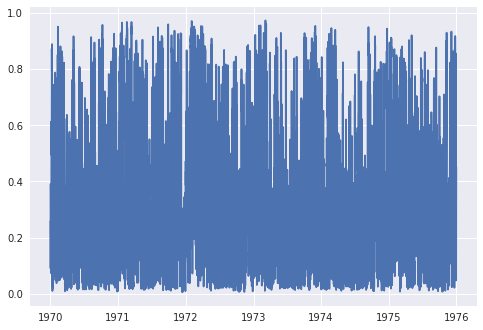

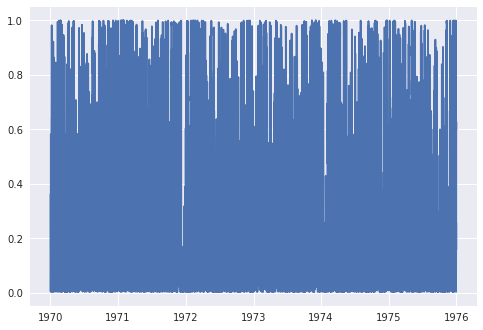

In [5]:
# All plots
#cap_fac_to_plot.plot(subplots=True, layout=(12,10))  # all as subplots

def plot_first_n_columns(model, time_period, n):
    for i in cap_factors_per_model[model][time_period].columns[:n]:  # slice as wish, all 113 take a long time to plot!
        plt.figure()
        plt.plot(cap_factors_per_model[model][time_period][i])
    plt.show()
    
plot_first_n_columns("MPI", "1970-1976", 5)

## Time series analysis

### Autocorrelation etc.

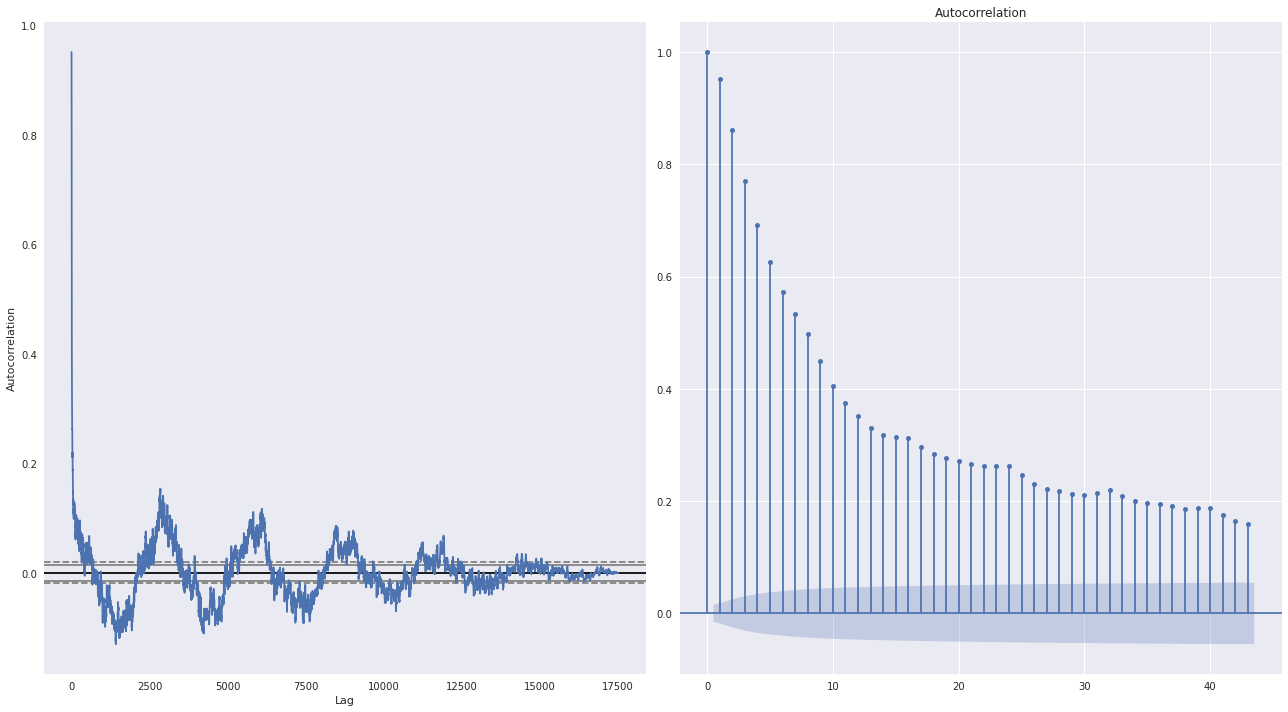

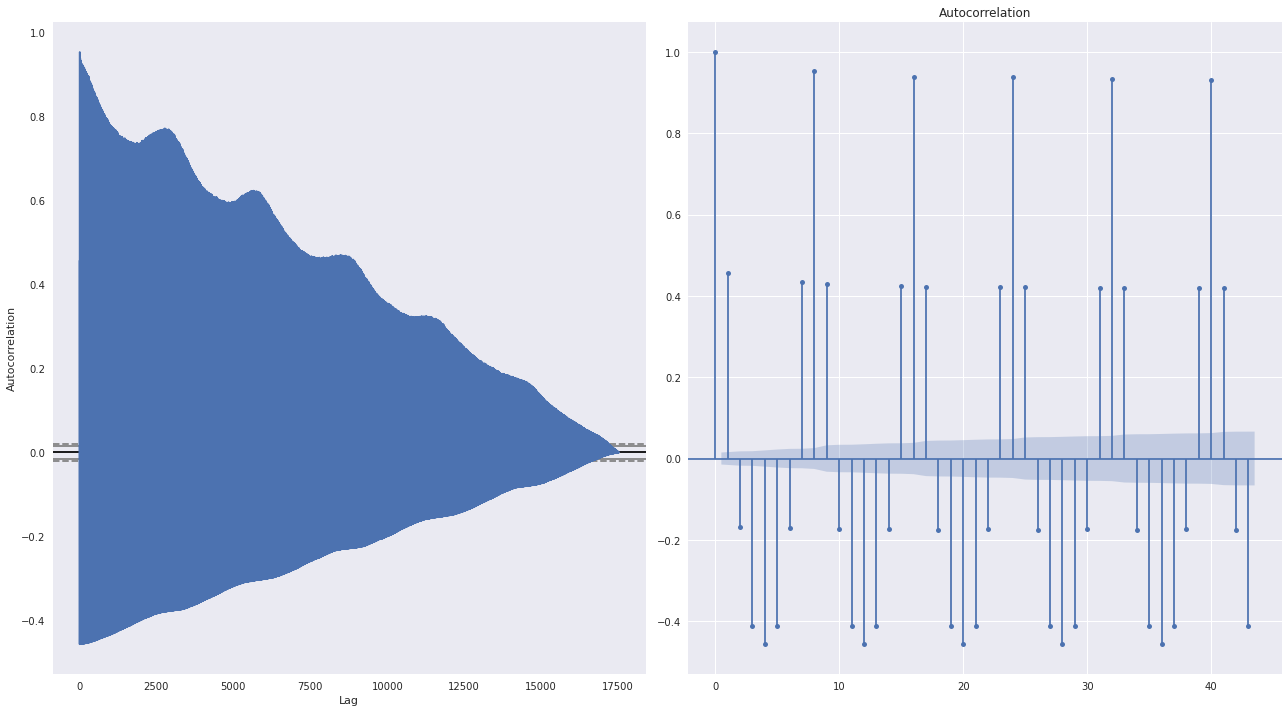

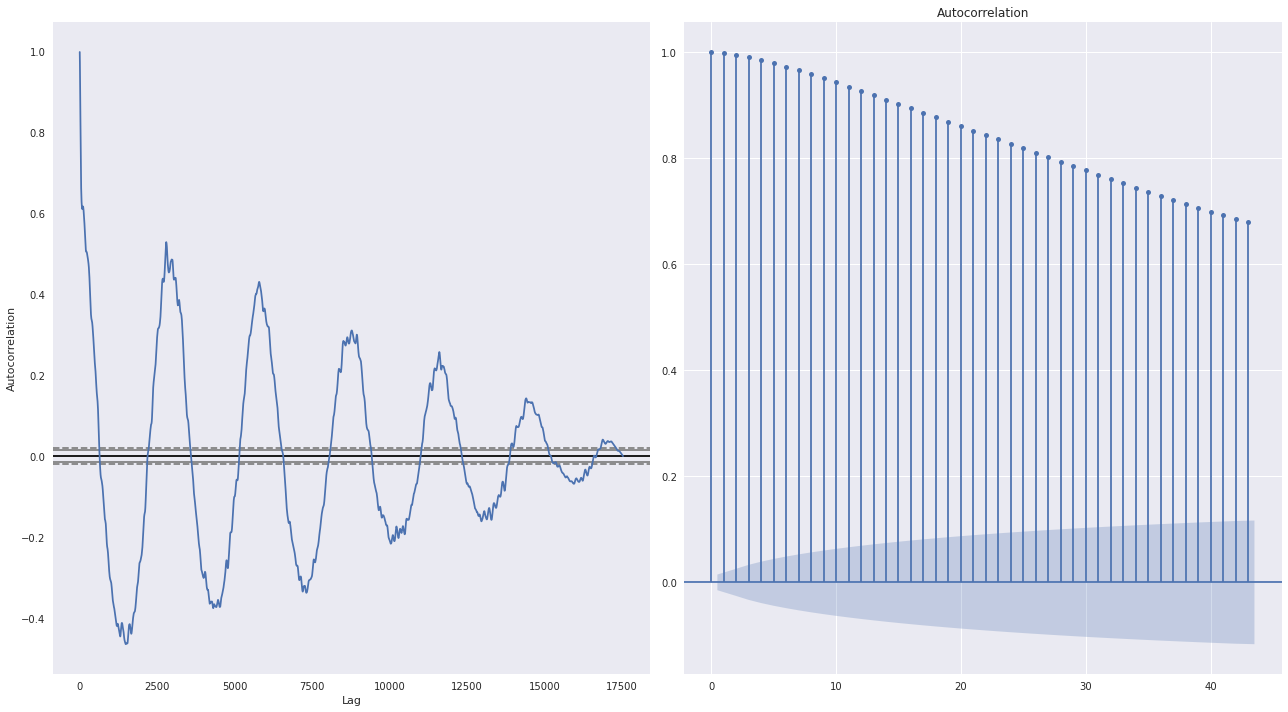

In [6]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorr(cap_factors_per_model, model, time_period, n_plots=None):
    cap_factors_per_model[model][time_period]
    count = 0
    for i in cap_fac_to_plot.columns[:10]:  # slice as wish, all 113 take a long time to plot!
        fig, axes = plt.subplots(1, 2, figsize=(18,10))  # two-column
        c = cap_fac_to_plot[i]
        # assign, else get duplicate plots - see: https://github.com/statsmodels/statsmodels/issues/1265
        a = plot_acf(c, ax=axes[1])
        autocorrelation_plot(c, ax=axes[0])

        fig.tight_layout()
        plt.show()
        count += 1
        if n_plots and count == n_plots:
            break  
        
plot_autocorr(cap_factors_per_model, "MPI", "1970-1976", 3)

In [7]:
# Values for all time series over all periods of one model
def get_autocorr_with_lag(cap_factors_per_model, model, use_lag):
    cap_factors = cap_factors_per_model[model]
    autocorrs_for_model = {}
    for period, cap_facs_per_period in cap_factors.items():
        autocorrs_for_model[period] = {}
        for name, cap_facs in cap_facs_per_period.items():
            #c = cap_fac_to_plot[name]
            a = cap_facs.autocorr(lag=use_lag)
            autocorrs_for_model[period][name] = a
            
    return autocorrs_for_model
    
# Check the data structure looks OK
###import pprint
###pprint.pprint(autocorrs_for_model)

# Assuming 3-hourly data (print(6*365*24/17528)  # = ~3)
points_per_day = 24/3
relevant_lags = [points_per_day, 7*points_per_day, 31*points_per_day, 365*points_per_day]  # daily, weekly, (roughly) monthly, yearly
print("USING LAGS OF", relevant_lags)

autocorrs_with_lag_per_model = {}
for model in models:
    autocorrs_with_lag_per_model[model] = [get_autocorr_with_lag(cap_factors_per_model, model, int(lag)) for lag in relevant_lags]

###pprint.pprint(autocorrs_with_lag_per_model)

USING LAGS OF [8.0, 56.0, 248.0, 2920.0]


****************************************************************************************************************************************************** Plotting: p_max_pu
**************************************************************************************************** Lag: 2920.0
Model: CNRM


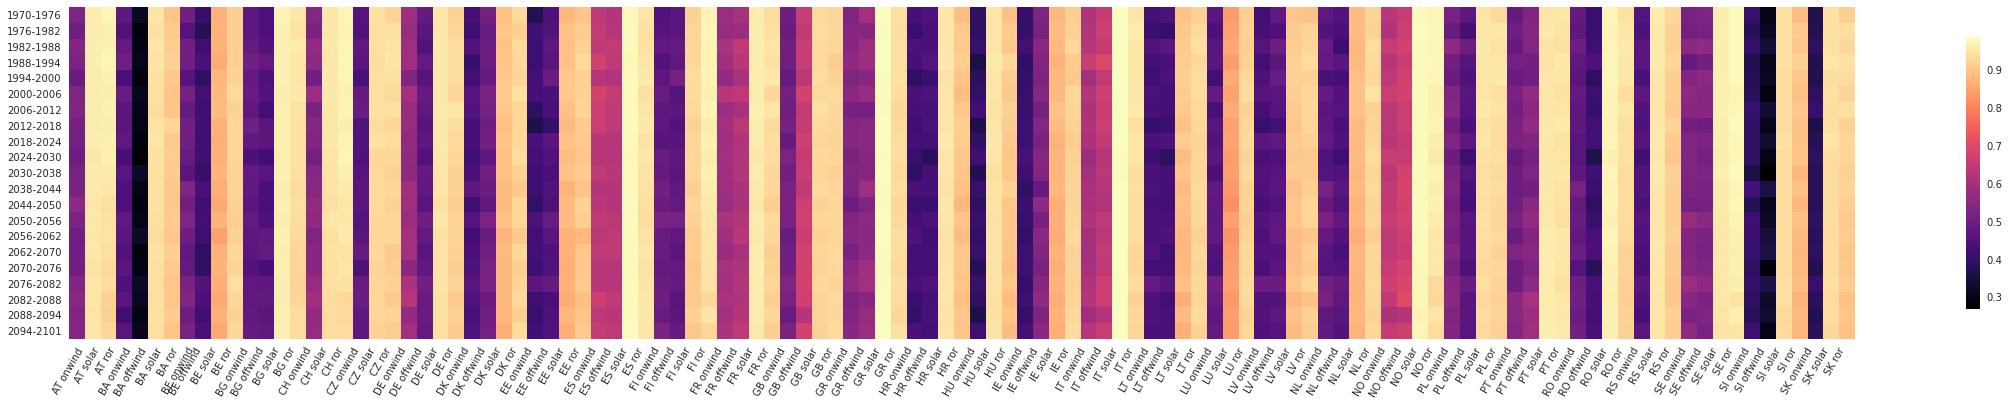

Model: ICHEC


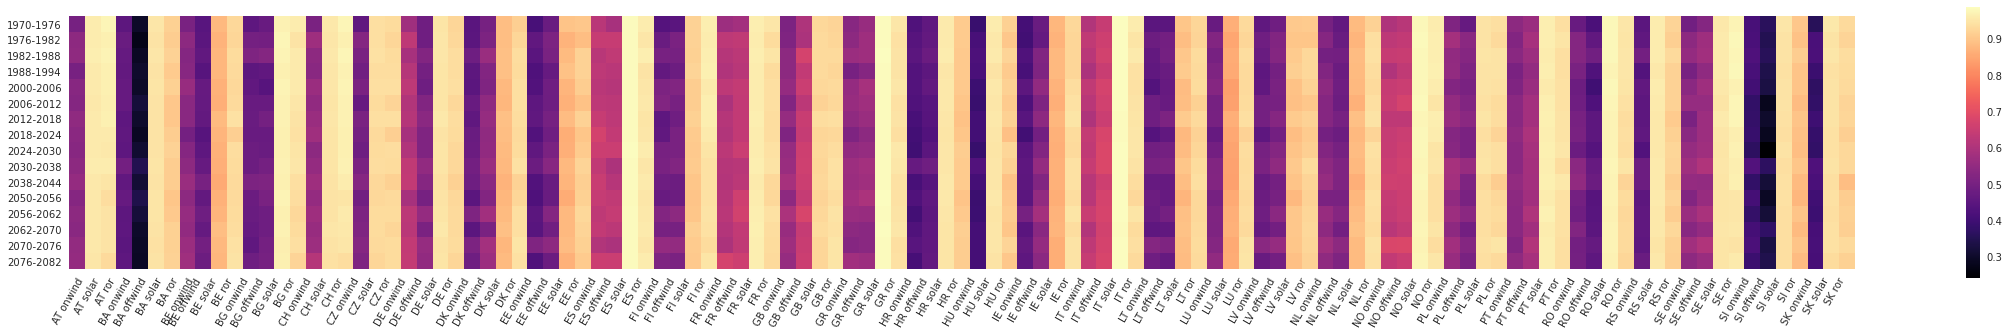

Model: MPI


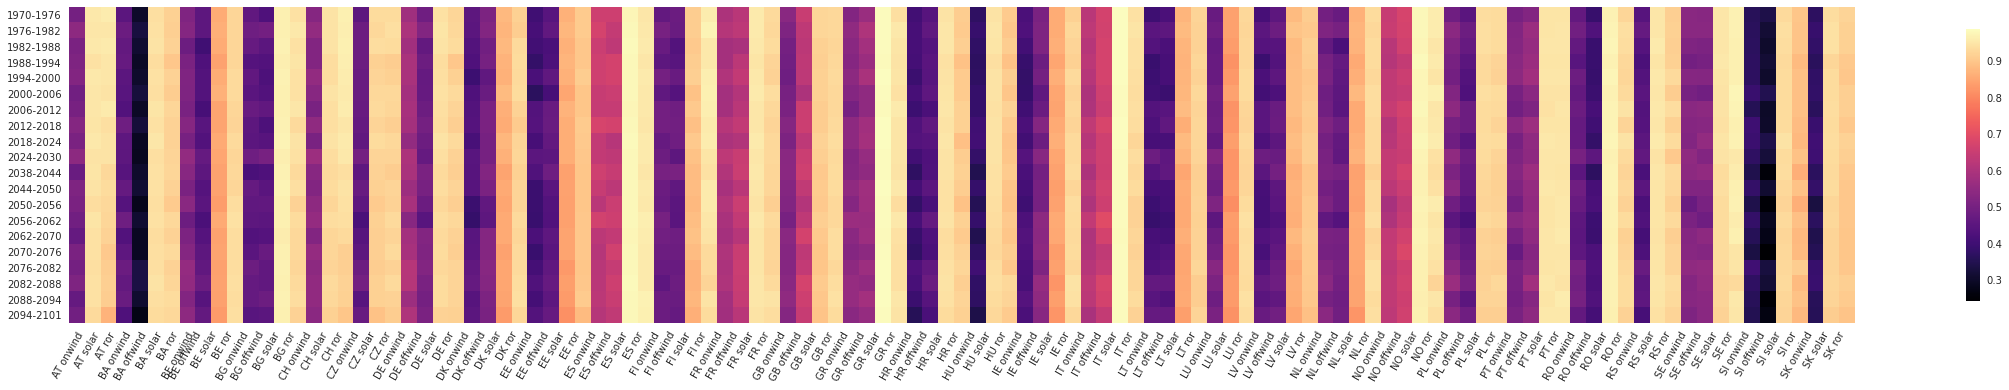

**************************************************************************************************** Lag: 8.0
Model: CNRM


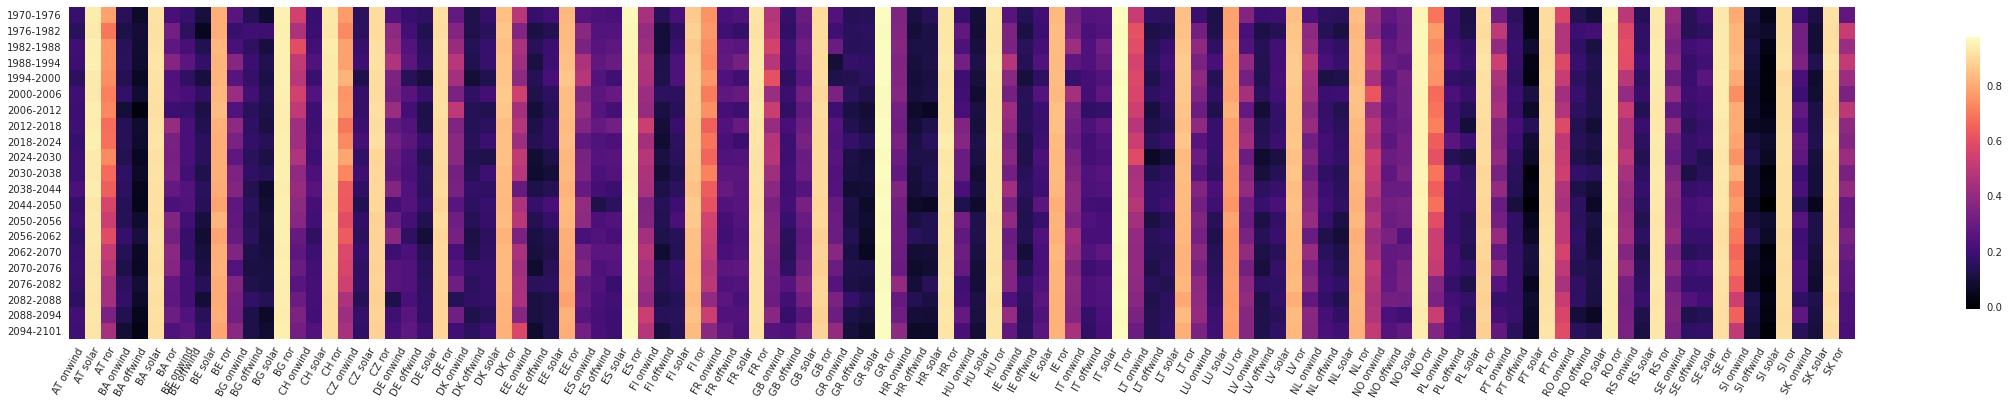

Model: ICHEC


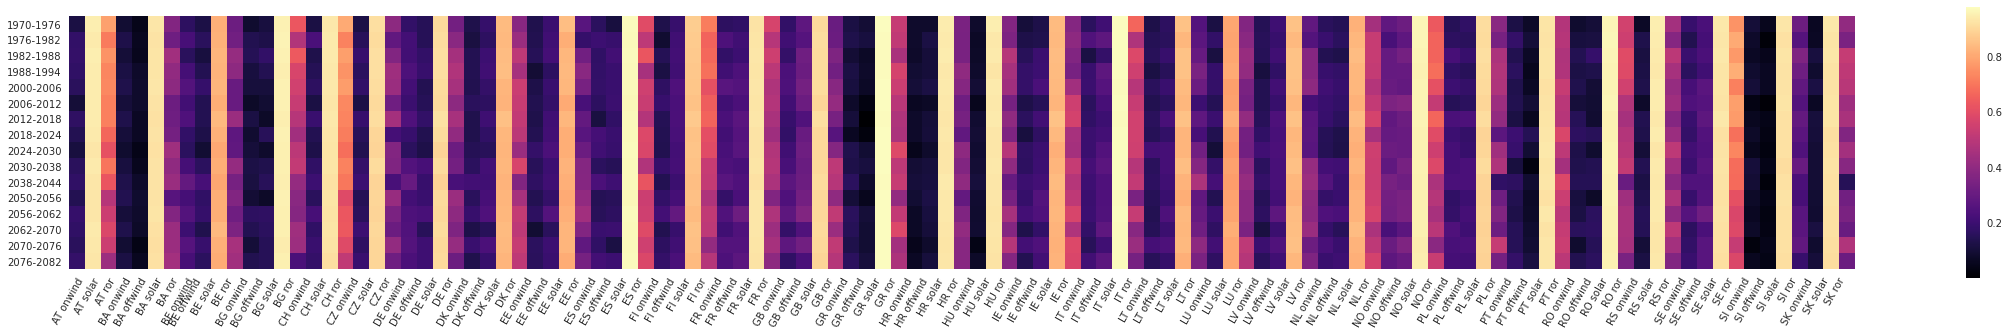

Model: MPI


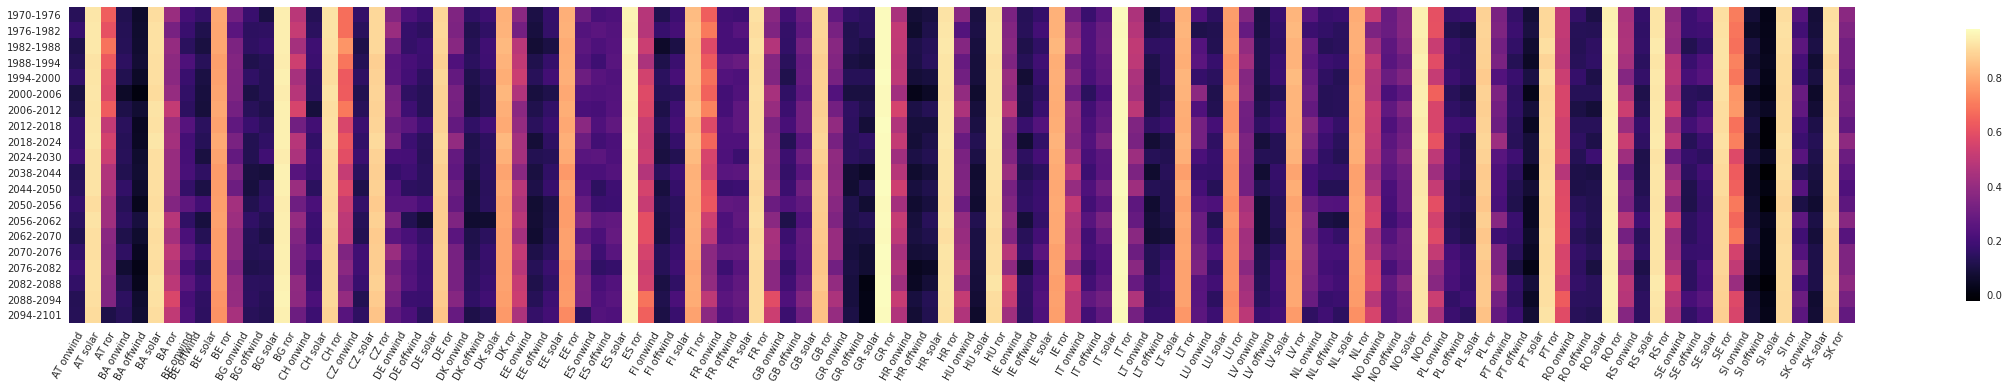

**************************************************************************************************** Lag: 56.0
Model: CNRM


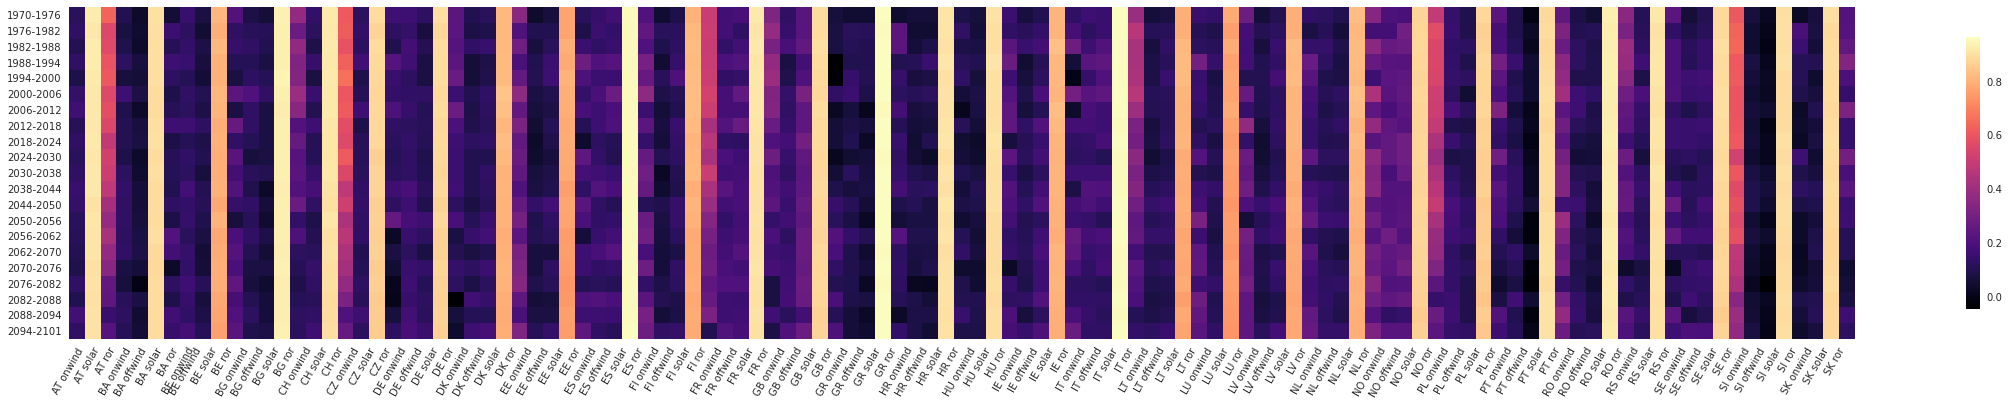

Model: ICHEC


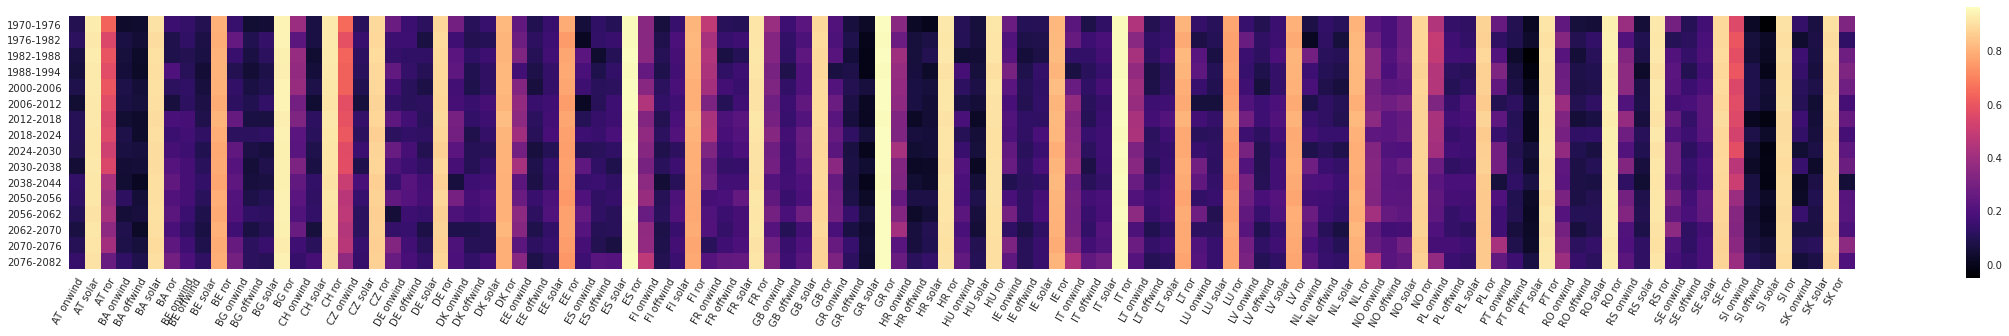

Model: MPI


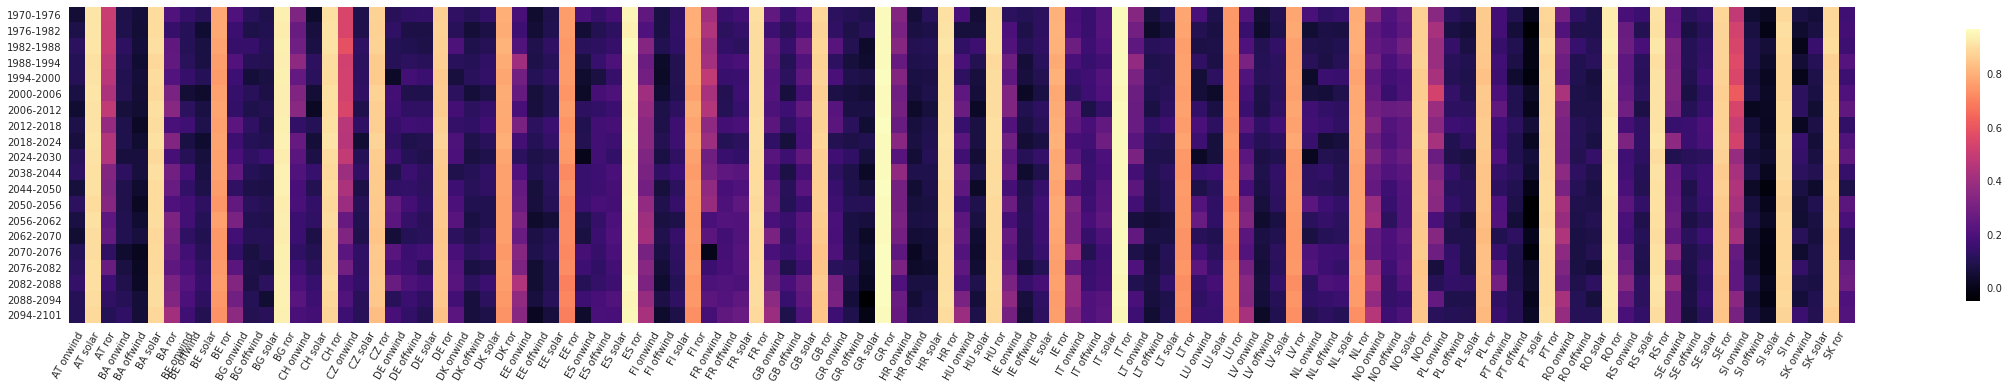

**************************************************************************************************** Lag: 248.0
Model: CNRM


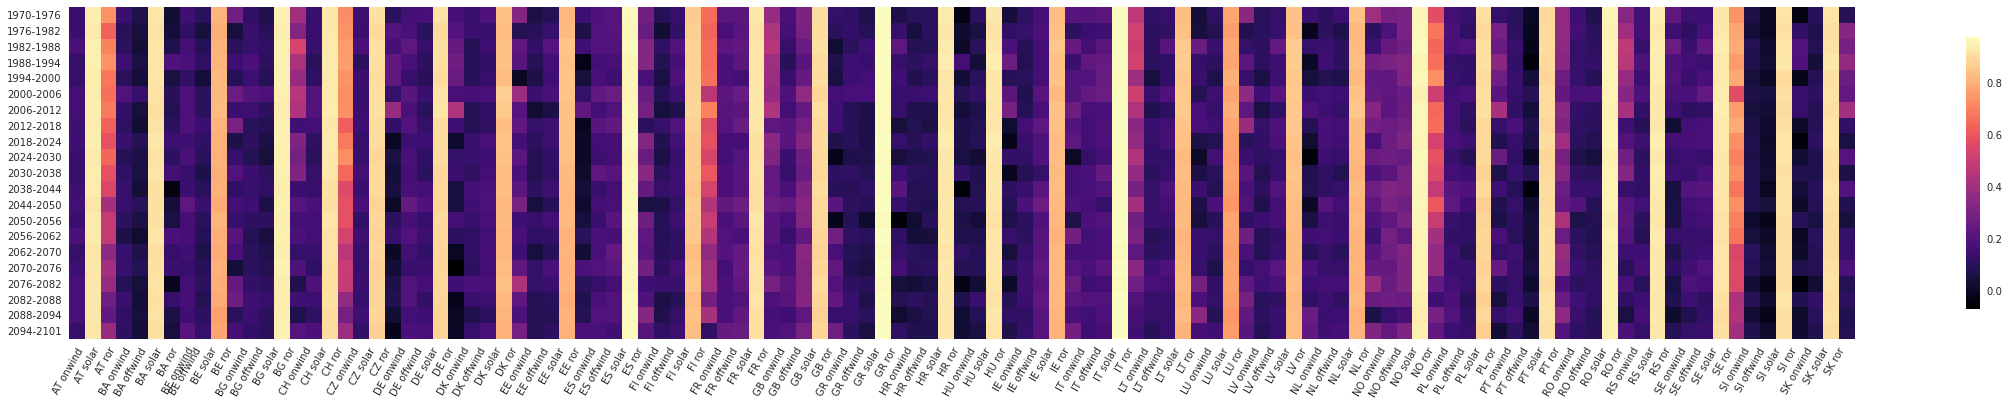

Model: ICHEC


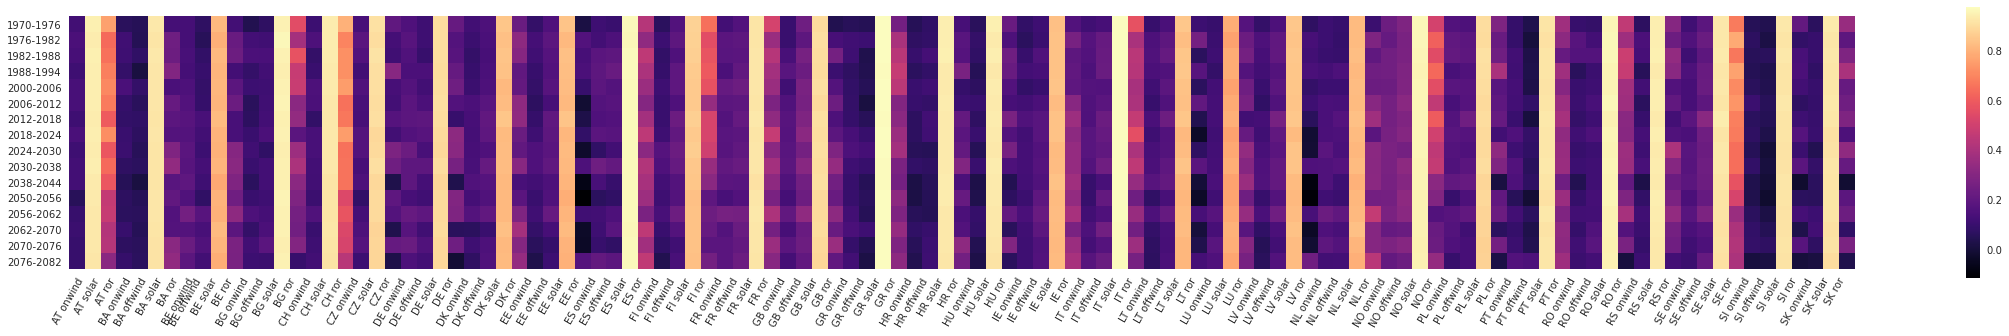

Model: MPI


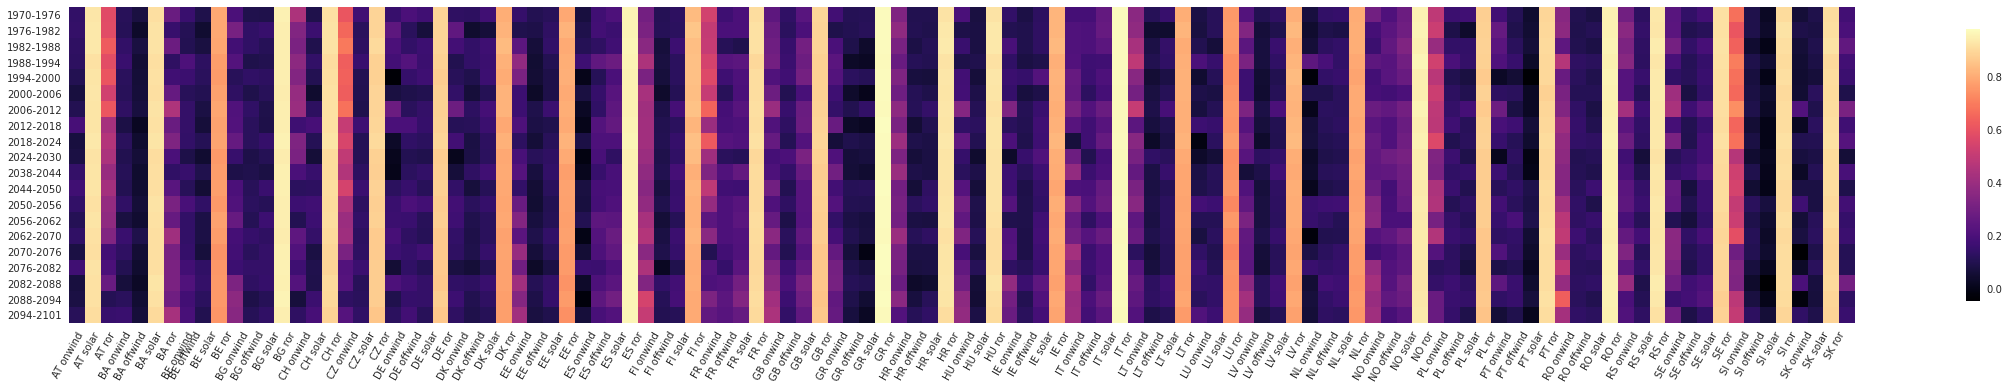

In [8]:
# Plotting them
import matplotlib.colors as mcolors

def plot_autocorr(autocorrs_for_model):
    # Set up plotting for the autocorrelations
    period_arrays = []
    ignore_periods = []
    for period, pdata in autocorrs_for_model.items():
        type_labels = list(pdata.keys())
        period_array = np.array(list(pdata.values()))
        # Filter out the single case when all data is NaN, len is 0:
        if len(period_array):
            period_arrays.append(period_array)  # in order
        else:
            ignore_periods.append(period)

    fig, ax = plt.subplots(figsize=(40, 10))
    d = np.stack(tuple(period_arrays))
    # Non-normalised:
    a = ax.imshow(d, cmap=plt.cm.magma)  #inferno)  #.cividis) #.PuBuGn) ### COLOURS

    # Labelling:
    period_labels = list(autocorrs_for_model.keys())
    try:
        period_labels.remove(ignore_periods[0])
    except Exception as msg: # for CNRM, lacking in ...
        pass
    plt.grid(False)
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
    ax.set_xticks(np.arange(len(type_labels)))
    ax.set_xticklabels(type_labels)
    ax.set_yticks(np.arange(len(period_labels)))
    ax.set_yticklabels(period_labels)
    fig.colorbar(a, shrink=0.5)
    plt.show()

    # Normalised:
    ###fig, ax = plt.subplots(figsize=(18,10))
    ###ax.imshow(im_data, cmap=plt.cm.coolwarm, norm=mcolors.CenteredNorm())


print("*****" * 30, f"Plotting: p_max_pu")
for i in range(len(relevant_lags)):
    print("*****" * 20, f"Lag: {relevant_lags[i-1]}")
    for model in models:
        print(f"Model: {model}")
        use = autocorrs_with_lag_per_model[model][i]
        plot_autocorr(use)

--------

### Decomposition, e.g. seasonality

<AxesSubplot:xlabel='name'>

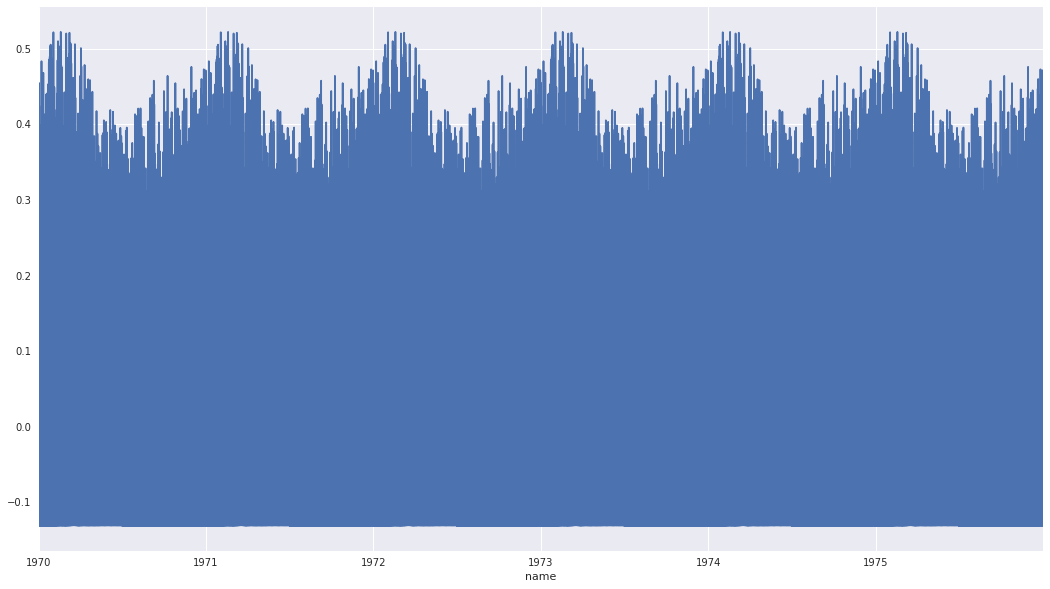

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonality example
fig, axes = plt.subplots(figsize=(18,10))  # two-column
result=seasonal_decompose(cap_fac_to_plot["AT solar"], model='linear', period=365*8)
result.seasonal.plot()

In [10]:
# TODO...